In [7]:
# Error Analysis for Financial Sentiment Classification
# This notebook performs detailed error analysis including:
# 1. Confusion matrix + per-class metrics
# 2. High-confidence wrong predictions
# 3. Low-confidence correct predictions  
# 4. Largest loss / smallest margin errors

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix, 
    classification_report,
    precision_recall_fscore_support
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Settings
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_colwidth', 100)

CLASS_LABELS = ['negative', 'neutral', 'positive']
RANDOM_SEED = 42

In [8]:
# Load predictions and original data
# Using RoBERTa-large-LoRA as the primary model for analysis

with open('../results/predictions/roberta_large_lora_predictions.pkl', 'rb') as f:
    results = pickle.load(f)

y_pred = results['RoBERTa-large-LoRA']
y_true = results['y_true']
probabilities = results['probabilities']

# Load original data to get the text
df = pd.read_csv('../data/data.csv')
df['labels'] = LabelEncoder().fit_transform(df['Sentiment'])
df.drop_duplicates(subset=['Sentence'], keep='first', inplace=True)

# Recreate the same train/test split
_, test_df = train_test_split(
    df, test_size=0.2, random_state=RANDOM_SEED, stratify=df['labels']
)
test_df = test_df.reset_index(drop=True)

# Verify alignment
print(f"Test set size: {len(test_df)}")
print(f"Predictions size: {len(y_pred)}")
print(f"Labels match: {np.array_equal(test_df['labels'].values, y_true)}")

Test set size: 1065
Predictions size: 1065
Labels match: True


In [9]:
# Create analysis dataframe with all relevant info
analysis_df = test_df.copy()
analysis_df['y_true'] = y_true
analysis_df['y_pred'] = y_pred
analysis_df['y_true_label'] = [CLASS_LABELS[i] for i in y_true]
analysis_df['y_pred_label'] = [CLASS_LABELS[i] for i in y_pred]
analysis_df['correct'] = y_true == y_pred

# Add probability columns
analysis_df['prob_negative'] = probabilities[:, 0]
analysis_df['prob_neutral'] = probabilities[:, 1]
analysis_df['prob_positive'] = probabilities[:, 2]

# Confidence = probability of predicted class
analysis_df['confidence'] = np.max(probabilities, axis=1)

# Probability of true class
analysis_df['prob_true_class'] = probabilities[np.arange(len(y_true)), y_true]

# Negative log-likelihood (loss) for the true class
analysis_df['nll_loss'] = -np.log(np.clip(analysis_df['prob_true_class'], 1e-10, 1.0))

# Margin: difference between top-1 and top-2 probabilities
sorted_probs = np.sort(probabilities, axis=1)
analysis_df['margin'] = sorted_probs[:, -1] - sorted_probs[:, -2]

print(f"Total samples: {len(analysis_df)}")
print(f"Correct: {analysis_df['correct'].sum()} ({analysis_df['correct'].mean()*100:.1f}%)")
print(f"Errors: {(~analysis_df['correct']).sum()} ({(~analysis_df['correct']).mean()*100:.1f}%)")
analysis_df.head()

Total samples: 1065
Correct: 927 (87.0%)
Errors: 138 (13.0%)


,Sentence,Sentiment,labels,y_true,y_pred,y_true_label,y_pred_label,correct,prob_negative,prob_neutral,prob_positive,confidence,prob_true_class,nll_loss,margin
0,"This implementation is very important to the operator , since it is about to launch its Fixed-to...",neutral,1,1,1,neutral,neutral,True,0.001172,0.976334,0.022494,0.976334,0.976334,0.023951,0.953839
1,"RAPALA TOURNAMENT FISHING : With all the major titles already out for the holidays , bargain-pri...",neutral,1,1,1,neutral,neutral,True,0.042675,0.955526,0.001799,0.955526,0.955526,0.045494,0.912850
2,Most bullish stocks on Twitter during this dip. $YHOO $GDX $GOOGL $STZ $GOLD $EW $VZ $CELG $SBUX...,positive,2,2,2,positive,positive,True,0.003940,0.001413,0.994647,0.994647,0.994647,0.005368,0.990707
3,The bank sees a potential for Getinge share to rise .,positive,2,2,2,positive,positive,True,0.000035,0.003180,0.996786,0.996786,0.996786,0.003220,0.993606
4,Finnish Componenta has published its new long-term strategy for the period 2011-2015 with the ai...,neutral,1,1,2,neutral,positive,False,0.000033,0.038541,0.961425,0.961425,0.038541,3.256022,0.922884


## Part 1A: Confusion Matrix + Per-Class Metrics

Key things to look for:
- **One class with terrible recall**: Model almost never predicts it
- **Neutral class as "trash can"**: Other classes get misclassified as neutral
- **Asymmetric confusion**: e.g., positive→neutral more common than neutral→positive

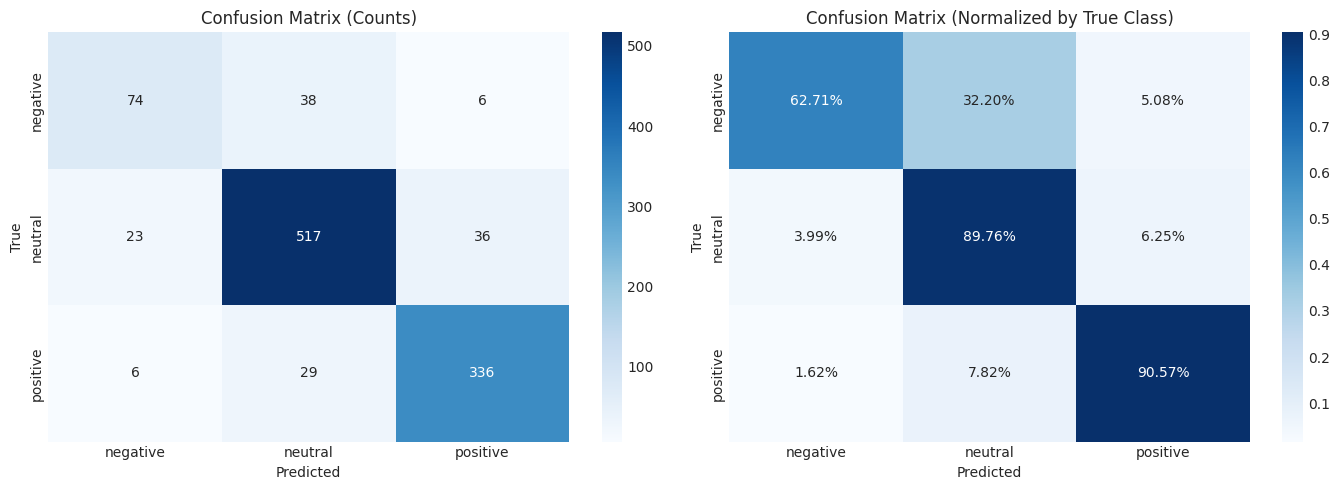


CONFUSION PATTERNS (where errors go)

NEGATIVE (n=118):
  Correctly classified: 74 (62.7%)
  → Confused as neutral: 38 (32.2%)
  → Confused as positive: 6 (5.1%)

NEUTRAL (n=576):
  Correctly classified: 517 (89.8%)
  → Confused as negative: 23 (4.0%)
  → Confused as positive: 36 (6.2%)

POSITIVE (n=371):
  Correctly classified: 336 (90.6%)
  → Confused as negative: 6 (1.6%)
  → Confused as neutral: 29 (7.8%)


In [10]:
# Confusion Matrix with detailed visualization
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Raw counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, ax=axes[0])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')
axes[0].set_title('Confusion Matrix (Counts)')

# Normalized (row-wise = recall perspective)
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
            xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS, ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('True')
axes[1].set_title('Confusion Matrix (Normalized by True Class)')

plt.tight_layout()
plt.show()

# Print confusion patterns
print("\n" + "="*60)
print("CONFUSION PATTERNS (where errors go)")
print("="*60)
for i, true_label in enumerate(CLASS_LABELS):
    total = cm[i].sum()
    correct = cm[i, i]
    print(f"\n{true_label.upper()} (n={total}):")
    print(f"  Correctly classified: {correct} ({100*correct/total:.1f}%)")
    for j, pred_label in enumerate(CLASS_LABELS):
        if i != j and cm[i, j] > 0:
            print(f"  → Confused as {pred_label}: {cm[i, j]} ({100*cm[i, j]/total:.1f}%)")

In [11]:
# Per-class metrics (not just macro averages!)
precision, recall, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=[0, 1, 2], zero_division=0
)

metrics_df = pd.DataFrame({
    'Class': CLASS_LABELS,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support.astype(int)
})

# Add prediction counts (how often model predicts each class)
pred_counts = np.bincount(y_pred, minlength=3)
metrics_df['Pred_Count'] = pred_counts
metrics_df['Pred_Rate'] = pred_counts / len(y_pred)
metrics_df['True_Rate'] = support / len(y_true)

print("="*70)
print("PER-CLASS METRICS")
print("="*70)
print(metrics_df.to_string(index=False))

# Diagnostic checks
print("\n" + "="*70)
print("DIAGNOSTIC FLAGS")
print("="*70)

for i, label in enumerate(CLASS_LABELS):
    issues = []
    
    # Check for terrible recall
    if recall[i] < 0.6:
        issues.append(f"⚠️  LOW RECALL ({recall[i]:.2f}): Model rarely correctly identifies {label}")
    
    # Check for terrible precision
    if precision[i] < 0.6:
        issues.append(f"⚠️  LOW PRECISION ({precision[i]:.2f}): Many false positives for {label}")
    
    # Check if class is under-predicted
    if metrics_df.loc[i, 'Pred_Rate'] < 0.5 * metrics_df.loc[i, 'True_Rate']:
        issues.append(f"⚠️  UNDER-PREDICTED: Model predicts {label} {metrics_df.loc[i, 'Pred_Rate']*100:.1f}% vs true {metrics_df.loc[i, 'True_Rate']*100:.1f}%")
    
    # Check if class is over-predicted (trash can)
    if metrics_df.loc[i, 'Pred_Rate'] > 1.5 * metrics_df.loc[i, 'True_Rate']:
        issues.append(f"⚠️  OVER-PREDICTED (trash can?): Model predicts {label} {metrics_df.loc[i, 'Pred_Rate']*100:.1f}% vs true {metrics_df.loc[i, 'True_Rate']*100:.1f}%")
    
    if issues:
        print(f"\n{label.upper()}:")
        for issue in issues:
            print(f"  {issue}")

if not any([recall[i] < 0.6 or precision[i] < 0.6 for i in range(3)]):
    print("\n✓ No major per-class issues detected")

PER-CLASS METRICS
   Class  Precision   Recall  F1-Score  Support  Pred_Count  Pred_Rate  True_Rate
negative   0.718447 0.627119  0.669683      118         103   0.096714   0.110798
 neutral   0.885274 0.897569  0.891379      576         584   0.548357   0.540845
positive   0.888889 0.905660  0.897196      371         378   0.354930   0.348357

DIAGNOSTIC FLAGS

✓ No major per-class issues detected


## Part 1B: Sort Errors by Risk

Three ranked lists to identify the most problematic predictions:

1. **High-confidence wrong** (confidence > 0.8 but incorrect) - Scariest failures
2. **Low-confidence correct** (correct but confidence < 0.5) - Fragile wins that may flip
3. **Largest loss / smallest margin** - Wrong with high NLL or tiny margin between classes

In [12]:
# 1. HIGH-CONFIDENCE WRONG: confidence > 0.8 but incorrect
# These are the scariest failures - model is confidently wrong

high_conf_wrong = analysis_df[
    (~analysis_df['correct']) & (analysis_df['confidence'] > 0.8)
].sort_values('confidence', ascending=False)

print("="*80)
print(f"HIGH-CONFIDENCE WRONG PREDICTIONS (n={len(high_conf_wrong)})")
print("Confidence > 0.8 but INCORRECT - These are your scariest failures")
print("="*80)

display_cols = ['Sentence', 'y_true_label', 'y_pred_label', 'confidence', 'margin']

if len(high_conf_wrong) > 0:
    print(f"\nFound {len(high_conf_wrong)} high-confidence errors ({100*len(high_conf_wrong)/len(analysis_df):.1f}% of test set)")
    print(f"These represent {100*len(high_conf_wrong)/(~analysis_df['correct']).sum():.1f}% of all errors\n")
    
    # Show top examples
    print("Top 15 worst offenders (sorted by confidence):")
    print("-"*80)
    for idx, row in high_conf_wrong.head(15).iterrows():
        print(f"\n[Conf: {row['confidence']:.3f}] TRUE: {row['y_true_label']} → PRED: {row['y_pred_label']}")
        print(f"   \"{row['Sentence'][:150]}{'...' if len(row['Sentence']) > 150 else ''}\"")
else:
    print("\n✓ No high-confidence wrong predictions found!")

HIGH-CONFIDENCE WRONG PREDICTIONS (n=52)
Confidence > 0.8 but INCORRECT - These are your scariest failures

Found 52 high-confidence errors (4.9% of test set)
These represent 37.7% of all errors

Top 15 worst offenders (sorted by confidence):
--------------------------------------------------------------------------------

[Conf: 0.998] TRUE: neutral → PRED: positive
   "UPDATE 1-SABMiller 2nd-quarter underlying sales rise, forex impacts margins"

[Conf: 0.991] TRUE: neutral → PRED: positive
   "Are ARM Holdings plc, Domino's Pizza Group plc and ASOS plc 3 must-have growth stocks?"

[Conf: 0.989] TRUE: neutral → PRED: positive
   "Coke dividend - 3%. Google dividend - 0%. For passive income Coke takes it. $GOOG $KO https://t.co/QBsoWjxOST"

[Conf: 0.985] TRUE: positive → PRED: neutral
   "The District Court of Helsinki dismissed all charges as the court of first instance in 2005 ."

[Conf: 0.982] TRUE: neutral → PRED: positive
   "Argentine agricultural export company Calafate has tapp

In [ ]:
# Breakdown of high-confidence errors by confusion type
if len(high_conf_wrong) > 0:
    print("\nBreakdown by confusion type:")
    print("-"*40)
    confusion_counts = high_conf_wrong.groupby(['y_true_label', 'y_pred_label']).size().sort_values(ascending=False)
    for (true_label, pred_label), count in confusion_counts.items():
        print(f"  {true_label} → {pred_label}: {count}")
    
    # Visualize distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Confidence distribution of high-conf errors
    axes[0].hist(high_conf_wrong['confidence'], bins=20, edgecolor='black', alpha=0.7)
    axes[0].set_xlabel('Confidence')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Confidence Distribution of High-Conf Errors')
    axes[0].axvline(x=0.9, color='red', linestyle='--', label='0.9 threshold')
    axes[0].legend()
    
    # By true class
    high_conf_wrong['y_true_label'].value_counts().plot(kind='bar', ax=axes[1], color='coral')
    axes[1].set_xlabel('True Class')
    axes[1].set_ylabel('Count')
    axes[1].set_title('High-Conf Errors by True Class')
    axes[1].tick_params(axis='x', rotation=0)
    
    plt.tight_layout()
    plt.show()

In [13]:
# 2. LOW-CONFIDENCE CORRECT: correct but confidence < 0.5
# These are "fragile wins" - predictions that could easily flip under distribution shift

low_conf_correct = analysis_df[
    (analysis_df['correct']) & (analysis_df['confidence'] < 0.5)
].sort_values('confidence', ascending=True)

print("="*80)
print(f"LOW-CONFIDENCE CORRECT PREDICTIONS (n={len(low_conf_correct)})")
print("Confidence < 0.5 but CORRECT - These are fragile wins that may flip under shift")
print("="*80)

if len(low_conf_correct) > 0:
    print(f"\nFound {len(low_conf_correct)} low-confidence correct predictions ({100*len(low_conf_correct)/len(analysis_df):.1f}% of test set)")
    print(f"These represent {100*len(low_conf_correct)/analysis_df['correct'].sum():.1f}% of all correct predictions\n")
    
    # Show examples
    print("Top 15 most fragile correct predictions (sorted by confidence, ascending):")
    print("-"*80)
    for idx, row in low_conf_correct.head(15).iterrows():
        print(f"\n[Conf: {row['confidence']:.3f}] TRUE/PRED: {row['y_true_label']} | Margin: {row['margin']:.3f}")
        print(f"   Probs: neg={row['prob_negative']:.2f}, neu={row['prob_neutral']:.2f}, pos={row['prob_positive']:.2f}")
        print(f"   \"{row['Sentence'][:150]}{'...' if len(row['Sentence']) > 150 else ''}\"")
else:
    print("\n✓ No low-confidence correct predictions found!")

LOW-CONFIDENCE CORRECT PREDICTIONS (n=2)
Confidence < 0.5 but CORRECT - These are fragile wins that may flip under shift

Found 2 low-confidence correct predictions (0.2% of test set)
These represent 0.2% of all correct predictions

Top 15 most fragile correct predictions (sorted by confidence, ascending):
--------------------------------------------------------------------------------

[Conf: 0.494] TRUE/PRED: neutral | Margin: 0.007
   Probs: neg=0.02, neu=0.49, pos=0.49
   "He is resting comfortably and is looking forward to getting back to work . ''"

[Conf: 0.499] TRUE/PRED: negative | Margin: 0.002
   Probs: neg=0.50, neu=0.50, pos=0.00
   "Finnish shipping company Finnlines , of the Grimaldi Group , reports its net sales decreased to EUR 241.8 mn in January-June 2009 from EUR 384.0 mn in..."


In [15]:
# 3. LARGEST LOSS / SMALLEST MARGIN ERRORS
# Wrong predictions with the highest NLL loss or smallest margin between classes

errors_df = analysis_df[~analysis_df['correct']].copy()

print("="*80)
print(f"LARGEST LOSS / SMALLEST MARGIN ERRORS (Total errors: {len(errors_df)})")
print("="*80)

# Sort by NLL loss (highest first)
errors_by_loss = errors_df.sort_values('nll_loss', ascending=False)

print("\n" + "-"*80)
print("TOP 15 ERRORS BY NLL LOSS (model assigned very low probability to true class)")
print("-"*80)
for idx, row in errors_by_loss.head(15).iterrows():
    print(f"\n[NLL: {row['nll_loss']:.3f}] [P(true): {row['prob_true_class']:.3f}] TRUE: {row['y_true_label']} → PRED: {row['y_pred_label']}")
    print(f"   Probs: neg={row['prob_negative']:.2f}, neu={row['prob_neutral']:.2f}, pos={row['prob_positive']:.2f}")
    print(f"   \"{row['Sentence'][:150]}{'...' if len(row['Sentence']) > 150 else ''}\"")

# Sort by margin (smallest first) - these are "close calls" that went wrong
errors_by_margin = errors_df.sort_values('margin', ascending=True)

print("\n" + "-"*80)
print("TOP 15 ERRORS BY SMALLEST MARGIN (model was uncertain but chose wrong)")
print("-"*80)
for idx, row in errors_by_margin.head(15).iterrows():
    print(f"\n[Margin: {row['margin']:.3f}] TRUE: {row['y_true_label']} → PRED: {row['y_pred_label']}")
    print(f"   Probs: neg={row['prob_negative']:.2f}, neu={row['prob_neutral']:.2f}, pos={row['prob_positive']:.2f}")
    print(f"   \"{row['Sentence'][:150]}{'...' if len(row['Sentence']) > 150 else ''}\"")


LARGEST LOSS / SMALLEST MARGIN ERRORS (Total errors: 138)

--------------------------------------------------------------------------------
TOP 15 ERRORS BY NLL LOSS (model assigned very low probability to true class)
--------------------------------------------------------------------------------

[NLL: 7.070] [P(true): 0.001] TRUE: neutral → PRED: positive
   Probs: neg=0.00, neu=0.00, pos=1.00
   "UPDATE 1-SABMiller 2nd-quarter underlying sales rise, forex impacts margins"

[NLL: 6.723] [P(true): 0.001] TRUE: positive → PRED: neutral
   Probs: neg=0.01, neu=0.98, pos=0.00
   "The District Court of Helsinki dismissed all charges as the court of first instance in 2005 ."

[NLL: 5.568] [P(true): 0.004] TRUE: neutral → PRED: positive
   Probs: neg=0.01, neu=0.00, pos=0.99
   "Coke dividend - 3%. Google dividend - 0%. For passive income Coke takes it. $GOOG $KO https://t.co/QBsoWjxOST"

[NLL: 4.754] [P(true): 0.009] TRUE: neutral → PRED: positive
   Probs: neg=0.00, neu=0.01, pos=0.99
  

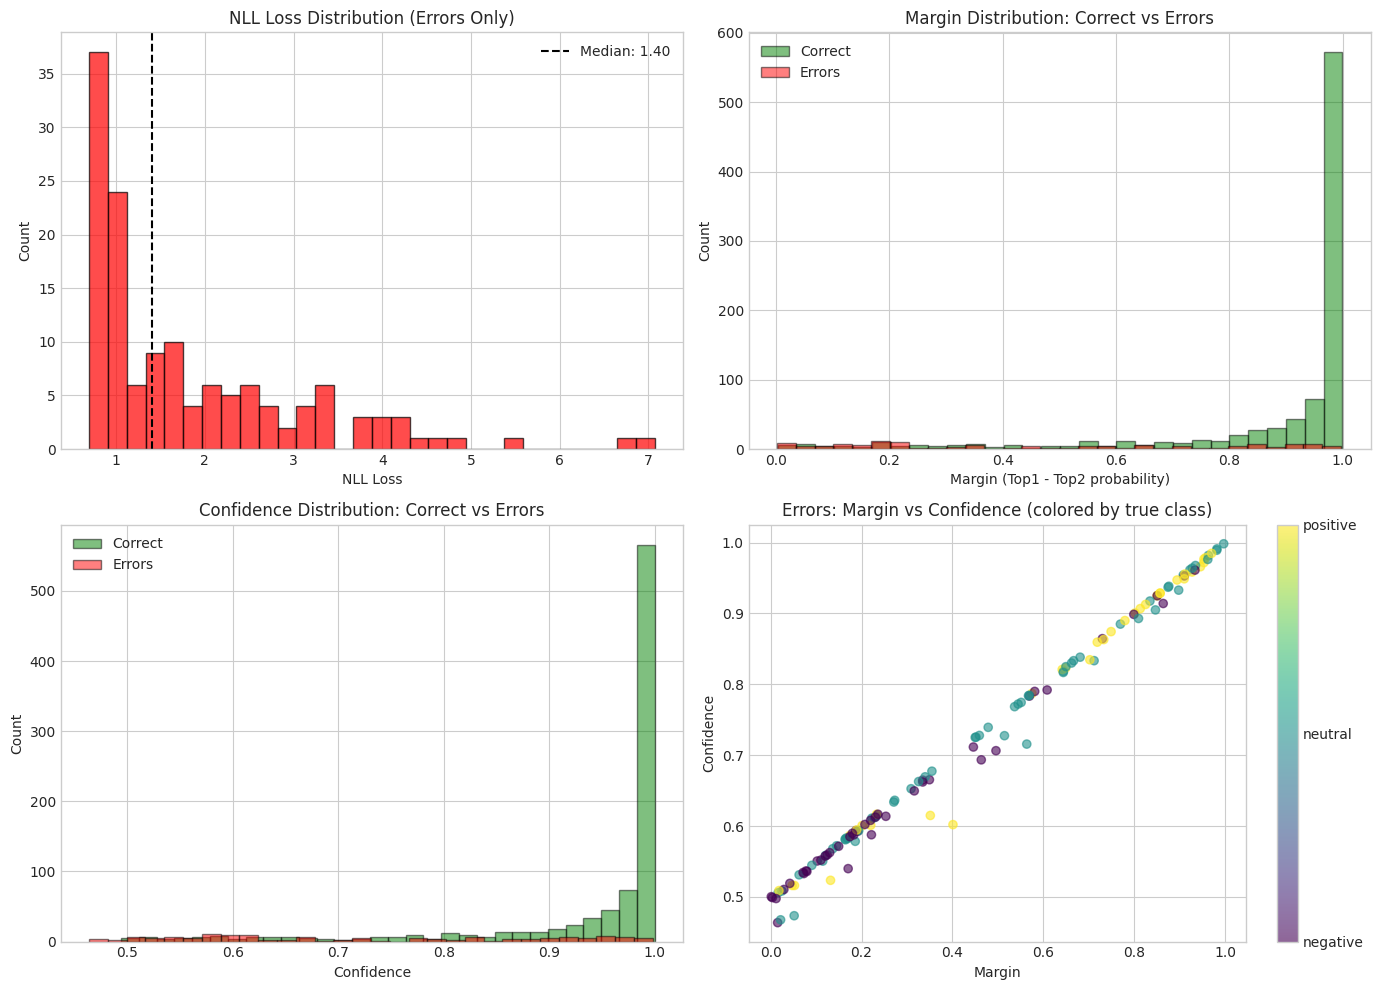

In [16]:
# Visualize the error distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. NLL Loss distribution for errors
axes[0, 0].hist(errors_df['nll_loss'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[0, 0].set_xlabel('NLL Loss')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('NLL Loss Distribution (Errors Only)')
axes[0, 0].axvline(x=errors_df['nll_loss'].median(), color='black', linestyle='--', 
                   label=f'Median: {errors_df["nll_loss"].median():.2f}')
axes[0, 0].legend()

# 2. Margin distribution: errors vs correct
axes[0, 1].hist(analysis_df[analysis_df['correct']]['margin'], bins=30, alpha=0.5, 
                label='Correct', color='green', edgecolor='black')
axes[0, 1].hist(analysis_df[~analysis_df['correct']]['margin'], bins=30, alpha=0.5, 
                label='Errors', color='red', edgecolor='black')
axes[0, 1].set_xlabel('Margin (Top1 - Top2 probability)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Margin Distribution: Correct vs Errors')
axes[0, 1].legend()

# 3. Confidence distribution: errors vs correct
axes[1, 0].hist(analysis_df[analysis_df['correct']]['confidence'], bins=30, alpha=0.5, 
                label='Correct', color='green', edgecolor='black')
axes[1, 0].hist(analysis_df[~analysis_df['correct']]['confidence'], bins=30, alpha=0.5, 
                label='Errors', color='red', edgecolor='black')
axes[1, 0].set_xlabel('Confidence')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_title('Confidence Distribution: Correct vs Errors')
axes[1, 0].legend()

# 4. Scatter: Margin vs Confidence for errors
scatter = axes[1, 1].scatter(errors_df['margin'], errors_df['confidence'], 
                              c=errors_df['y_true'], cmap='viridis', alpha=0.6)
axes[1, 1].set_xlabel('Margin')
axes[1, 1].set_ylabel('Confidence')
axes[1, 1].set_title('Errors: Margin vs Confidence (colored by true class)')
cbar = plt.colorbar(scatter, ax=axes[1, 1], ticks=[0, 1, 2])
cbar.set_ticklabels(CLASS_LABELS)

plt.tight_layout()
plt.show()

In [17]:
# Summary statistics
print("="*80)
print("ERROR ANALYSIS SUMMARY")
print("="*80)

print(f"\nTotal test samples: {len(analysis_df)}")
print(f"Total errors: {len(errors_df)} ({100*len(errors_df)/len(analysis_df):.1f}%)")

print(f"\n{'Category':<40} {'Count':>8} {'% of Errors':>12} {'% of Total':>12}")
print("-"*80)

# High-confidence wrong
hc_wrong = len(high_conf_wrong)
print(f"{'High-confidence wrong (conf > 0.8)':<40} {hc_wrong:>8} {100*hc_wrong/len(errors_df):>11.1f}% {100*hc_wrong/len(analysis_df):>11.1f}%")

# Very high confidence wrong
vhc_wrong = len(analysis_df[(~analysis_df['correct']) & (analysis_df['confidence'] > 0.9)])
print(f"{'Very high-conf wrong (conf > 0.9)':<40} {vhc_wrong:>8} {100*vhc_wrong/len(errors_df):>11.1f}% {100*vhc_wrong/len(analysis_df):>11.1f}%")

# Low-confidence correct
lc_correct = len(low_conf_correct)
print(f"{'Low-confidence correct (conf < 0.5)':<40} {lc_correct:>8} {'N/A':>12} {100*lc_correct/len(analysis_df):>11.1f}%")

# Very low margin errors
low_margin_errors = len(errors_df[errors_df['margin'] < 0.2])
print(f"{'Low-margin errors (margin < 0.2)':<40} {low_margin_errors:>8} {100*low_margin_errors/len(errors_df):>11.1f}% {100*low_margin_errors/len(analysis_df):>11.1f}%")

# High loss errors
high_loss_errors = len(errors_df[errors_df['nll_loss'] > 2.0])
print(f"{'High-loss errors (NLL > 2.0)':<40} {high_loss_errors:>8} {100*high_loss_errors/len(errors_df):>11.1f}% {100*high_loss_errors/len(analysis_df):>11.1f}%")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Automated insights
insights = []

if hc_wrong > 0.1 * len(errors_df):
    insights.append(f"⚠️  {100*hc_wrong/len(errors_df):.0f}% of errors are high-confidence - model is overconfident")

if lc_correct > 0.05 * len(analysis_df):
    insights.append(f"⚠️  {100*lc_correct/len(analysis_df):.0f}% of predictions are fragile wins - may not generalize")

if low_margin_errors > 0.5 * len(errors_df):
    insights.append(f"✓ {100*low_margin_errors/len(errors_df):.0f}% of errors have low margin - model knows it's uncertain")

for i, label in enumerate(CLASS_LABELS):
    class_errors = errors_df[errors_df['y_true'] == i]
    if len(class_errors) > 0:
        class_hc_errors = class_errors[class_errors['confidence'] > 0.8]
        if len(class_hc_errors) > 0.3 * len(class_errors):
            insights.append(f"⚠️  {label}: {100*len(class_hc_errors)/len(class_errors):.0f}% of errors are high-confidence")

for insight in insights:
    print(f"\n{insight}")

if not insights:
    print("\n✓ No major red flags detected in error analysis")

ERROR ANALYSIS SUMMARY

Total test samples: 1065
Total errors: 138 (13.0%)

Category                                    Count  % of Errors   % of Total
--------------------------------------------------------------------------------
High-confidence wrong (conf > 0.8)             52        37.7%         4.9%
Very high-conf wrong (conf > 0.9)              34        24.6%         3.2%
Low-confidence correct (conf < 0.5)             2          N/A         0.2%
Low-margin errors (margin < 0.2)               44        31.9%         4.1%
High-loss errors (NLL > 2.0)                   48        34.8%         4.5%

KEY INSIGHTS

⚠️  38% of errors are high-confidence - model is overconfident

⚠️  neutral: 39% of errors are high-confidence

⚠️  positive: 66% of errors are high-confidence


In [18]:
# Export error lists for further analysis
export_cols = ['Sentence', 'Sentiment', 'y_true_label', 'y_pred_label', 
               'confidence', 'margin', 'nll_loss', 'prob_negative', 'prob_neutral', 'prob_positive']

# Save the three key error lists
high_conf_wrong[export_cols].to_csv('../results/errors_high_confidence_wrong.csv', index=False)
low_conf_correct[export_cols].to_csv('../results/errors_low_confidence_correct.csv', index=False)
errors_by_loss.head(50)[export_cols].to_csv('../results/errors_highest_loss.csv', index=False)

print("Exported error lists to ../results/:")
print("  - errors_high_confidence_wrong.csv")
print("  - errors_low_confidence_correct.csv") 
print("  - errors_highest_loss.csv (top 50)")

Exported error lists to ../results/:
  - errors_high_confidence_wrong.csv
  - errors_low_confidence_correct.csv
  - errors_highest_loss.csv (top 50)
